## Base: Airline passenger satisfaction

* https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelo machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Métricas
from sklearn.metrics import (recall_score,
                             accuracy_score,
                             precision_score,
                             f1_score)
from sklearn.metrics import classification_report

# Seleção de características
from sklearn.feature_selection import (SequentialFeatureSelector,
                                       RFE)
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [83]:
##### Bibliotecas externas

# Plotar o diagram de Venn
!pip install venn

### Carrega a base

In [84]:
def carregaBaseDados(nome):
  return pd.read_csv(nome)

### Dados Faltantes e atributos irrelevantes

In [85]:
def limpezaDados(dataframe, rem_cols, class_column):

  # Remoção de columnas irrelevantes
  dataframe.drop(rem_cols, axis=1, inplace=True)

  # Transforma os dados da classe satisfaction
  labelencoder = LabelEncoder()
  dataframe[class_column] = labelencoder.fit_transform(dataframe[class_column])

In [86]:
def geraNulos(dataframe, column, size):
  change = dataframe.sample(size).index
  dataframe.loc[change,column] = np.nan

### Separação entre treino e teste

In [87]:
# Separa atributos da classe (X,y)
def separaClasse(dataframe, classe):
  X = dataframe.drop([classe], axis = 1)
  y = dataframe[classe]
  return X,y

In [88]:
# Separa os conjuntos em treino e teste (70%/30%)
def separaTreinoTeste(X, y):
  return train_test_split(X,y, test_size=0.3)

### Modelo preditivo

In [89]:
# Gera o modelo preditivo
def geraModelo(modelo, X,y):
  # modelo = 'DecisionTreeClassifier()'
  modelo = eval(modelo)
  modelo.fit(X,y)
  return modelo

### Métricas

In [90]:
def geraMetricas(y_test, y_pred):
  # Acuracidade
  print("ACC: %.3f" %(accuracy_score(y_test,y_pred)))
  #Revocação
  print("Recall :%.2f" %(recall_score(y_test,y_pred)))
  #Precisão
  print("Precision :%.2f" %(precision_score(y_test,y_pred)))
  #F1-score
  print("F1-score :%.2f" %(f1_score(y_test,y_pred)))


In [91]:
def metricaReport(y_test, y_pred):
  print(classification_report(y_test, y_pred))

## Seleção de Características

In [92]:
def geraMapaCalor(dataframe):
  plt.figure(figsize = (15, 10))
  sns.heatmap(dataframe.corr(), cmap = 'Blues')
  plt.title("Correlações entre os atributos", size = 20)
  plt.show()

In [93]:
# Sequential feature selection
def featureSelectionSFS(clf, direction, total_features):
  sfs = SequentialFeatureSelector(estimator = eval(clf),
          n_features_to_select = total_features,
          direction = direction,
          scoring = 'accuracy')
  return sfs

In [94]:
# Recursive Feature Elimination
def featureSelectionRFE(clf, total_features):
  rfe = RFE(estimator = eval(clf),
          n_features_to_select = total_features)
  return rfe

In [95]:
# Verifica os nomes das colunas selecionadas
def getFeaturesName(selBestModel):
  return selBestModel.get_feature_names_out().tolist()

In [96]:
# Aplica a transformação (Redução) no conjunto Treino e Teste
def changeData(selBestModel, X):
  return selBestModel.transform(X)


### Realizando testes com os dados:

Etapas do pipeline:
* https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [97]:
def geraPipeline(dataframe, modelo, fs):

  ### Preprocessamento
  # Seleciona os atributos numéricos e categóricos
  numeric_features = dataframe.select_dtypes(include=['int64','float64']).columns
  categorical_features = dataframe.select_dtypes(include=['object']).columns

  # Define os tipos de transformações nos atributos
  numeric_transformer = Pipeline(
      steps=[("imputer", SimpleImputer(strategy="median")),
             ("scaler", StandardScaler())]
  )
  categorical_transformer = Pipeline(
      steps=[("encoder", OneHotEncoder()),
             ("imputer", SimpleImputer(strategy="most_frequent"))]
  )

  # Combina as multiplas transformações com ColumnTransformer
  preprocessor = ColumnTransformer(
      transformers=[("num", numeric_transformer, numeric_features),
                    ("cat", categorical_transformer, categorical_features)]
  )

  # Gera o pipeline final
  pipeline = Pipeline(
      steps=[("preprocessor",preprocessor),
             ("featureSelection", fs),
             ("classifier",eval(modelo))])

  return pipeline


In [98]:
# Gera o dataframe
df = carregaBaseDados('test.csv')

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [100]:
## Preparação dos dados
# remoção de columas e discretização da classe
limpezaDados(df, ['Unnamed: 0', 'id'], 'satisfaction')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             25976 non-null  object 
 1   Customer Type                      25976 non-null  object 
 2   Age                                25976 non-null  int64  
 3   Type of Travel                     25976 non-null  object 
 4   Class                              25976 non-null  object 
 5   Flight Distance                    25976 non-null  int64  
 6   Inflight wifi service              25976 non-null  int64  
 7   Departure/Arrival time convenient  25976 non-null  int64  
 8   Ease of Online booking             25976 non-null  int64  
 9   Gate location                      25976 non-null  int64  
 10  Food and drink                     25976 non-null  int64  
 11  Online boarding                    25976 non-null  int

In [101]:
# Gera Nan values
geraNulos(df, 'Class', 10)

In [102]:
df.isna().sum()

Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                10
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

In [103]:
# Separa atributos e classe
X,y = separaClasse(df, 'satisfaction')

In [104]:
# Gerar conjunto treino e teste
X_train, X_test, y_train, y_test = separaTreinoTeste(X, y)

Forward

In [105]:
# Gera o pipeline
pipe = geraPipeline(X,
                    'DecisionTreeClassifier()',
                    featureSelectionSFS('DecisionTreeClassifier()','forward',9),
                    )
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainm...
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['Gender', 'Customer Type', 'Type of Travel', 'Class'], dtype='object'))])),
                ('featureSelection',
                 SequentialFeatureSelector(estimator=DecisionTreeClassifier(),
                                           n_features_to_select=9,
                                           scoring='accuracy')),
                ('classifier', DecisionTreeClassifier())])

In [106]:
# Avalia o modelo com mais métricas
geraMetricas(y_test, pipe.predict(X_test))

ACC: 0.945
Recall :0.93
Precision :0.94
F1-score :0.94


In [107]:
pipe[:-1].get_feature_names_out()

array(['num__Inflight wifi service', 'num__Gate location',
       'num__Online boarding', 'num__Inflight entertainment',
       'cat__Customer Type_Loyal Customer',
       'cat__Type of Travel_Business travel',
       'cat__Type of Travel_Personal Travel', 'cat__Class_Business',
       'cat__Class_nan'], dtype=object)

In [108]:
# Selecionar os nomes das features
features_Forward = getFeaturesName(pipe[:-1])

In [109]:
features_Forward

['num__Inflight wifi service',
 'num__Gate location',
 'num__Online boarding',
 'num__Inflight entertainment',
 'cat__Customer Type_Loyal Customer',
 'cat__Type of Travel_Business travel',
 'cat__Type of Travel_Personal Travel',
 'cat__Class_Business',
 'cat__Class_nan']

Backward

In [110]:
# Gera o pipeline Backward
pipe = geraPipeline(X,
                    'DecisionTreeClassifier()',
                    featureSelectionSFS('DecisionTreeClassifier()','backward',9),
                    )
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainm...
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['Gender', 'Customer Type', 'Type of Travel', 'Class'], dtype='object'))])),
                ('featureSelection',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=DecisionTreeClassifier(),
                                           n_features_to_select=9,
                                           scoring='accuracy')),
                ('classifier', DecisionTreeClassifier())])

In [111]:
# Avalia o modelo com mais métricas
geraMetricas(y_test, pipe.predict(X_test))

ACC: 0.945
Recall :0.93
Precision :0.94
F1-score :0.94


In [112]:
# Seleciona o nome das features
features_Backward = getFeaturesName(pipe[:-1])

In [113]:
features_Backward

['num__Inflight wifi service',
 'num__Gate location',
 'num__Online boarding',
 'num__Seat comfort',
 'num__Inflight entertainment',
 'num__Baggage handling',
 'cat__Customer Type_Loyal Customer',
 'cat__Type of Travel_Business travel',
 'cat__Class_Business']

RFE

In [114]:
# Gera o pipeline RFE
pipe = geraPipeline(X,
                    'DecisionTreeClassifier()',
                    featureSelectionRFE('DecisionTreeClassifier()',9))
pipe.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainm...
       'Cleanliness', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['Gender', 'Customer Type', 'Type of Travel', 'Class'], dtype='object'))])),
                ('featureSelection',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=9)),
                ('classifier', DecisionTreeClassifier())])

In [115]:
# Avalia o modelo com mais métricas
geraMetricas(y_test, pipe.predict(X_test))


ACC: 0.907
Recall :0.90
Precision :0.89
F1-score :0.89


In [116]:
features_RFE = getFeaturesName(pipe[:-1])

In [117]:
features_RFE

['num__Age',
 'num__Flight Distance',
 'num__Inflight wifi service',
 'num__Online boarding',
 'num__Seat comfort',
 'num__Inflight entertainment',
 'num__Baggage handling',
 'num__Checkin service',
 'cat__Type of Travel_Personal Travel']

#### Similaridade das Features

In [118]:
# Diagrama de Venn
from venn import venn

In [119]:
features = {
    "Step Forward": set(features_Forward),
    "Step Backward": set(features_Backward),
    "RFE": set(features_RFE),
}

In [120]:
features

{'Step Forward': {'cat__Class_Business',
  'cat__Class_nan',
  'cat__Customer Type_Loyal Customer',
  'cat__Type of Travel_Business travel',
  'cat__Type of Travel_Personal Travel',
  'num__Gate location',
  'num__Inflight entertainment',
  'num__Inflight wifi service',
  'num__Online boarding'},
 'Step Backward': {'cat__Class_Business',
  'cat__Customer Type_Loyal Customer',
  'cat__Type of Travel_Business travel',
  'num__Baggage handling',
  'num__Gate location',
  'num__Inflight entertainment',
  'num__Inflight wifi service',
  'num__Online boarding',
  'num__Seat comfort'},
 'RFE': {'cat__Type of Travel_Personal Travel',
  'num__Age',
  'num__Baggage handling',
  'num__Checkin service',
  'num__Flight Distance',
  'num__Inflight entertainment',
  'num__Inflight wifi service',
  'num__Online boarding',
  'num__Seat comfort'}}

<Axes: >

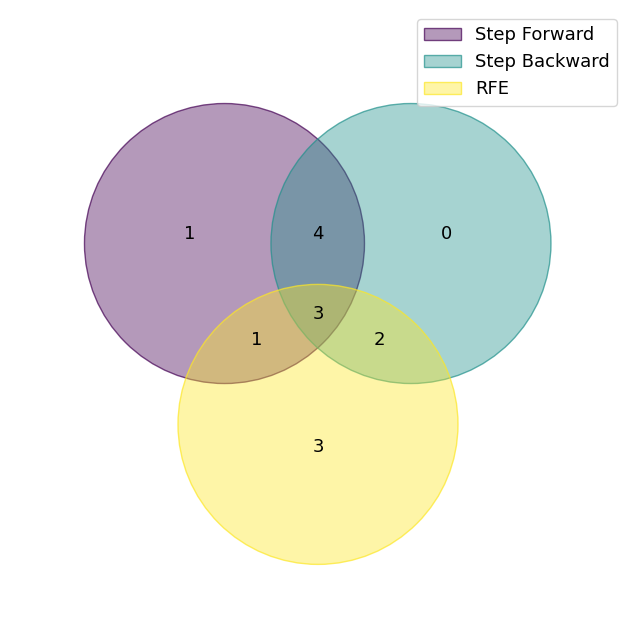

In [121]:
venn(features)

In [122]:
set(features_Forward).intersection(features_Backward,features_RFE)

{'num__Inflight entertainment',
 'num__Inflight wifi service',
 'num__Online boarding'}

In [123]:
set(features_Forward).difference(features_Backward, features_RFE)

{'cat__Class_nan'}

In [124]:
set(features_Forward).difference(features_RFE)

{'cat__Class_Business',
 'cat__Class_nan',
 'cat__Customer Type_Loyal Customer',
 'cat__Type of Travel_Business travel',
 'num__Gate location'}